In [1]:
import torch
import cv2 as cv
import pylab
import numpy as np

In [2]:
video_filename = 'data/train.mp4'
labels_filename = 'data/train.txt'
print('Reading training video file: {}'.format(video_filename))
reader = cv.VideoCapture(video_filename)

Reading training video file: data/train.mp4


Image size: (640,480)


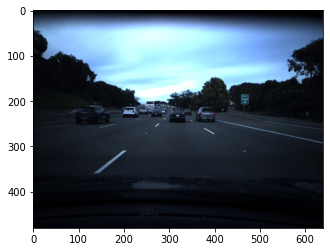

In [3]:
# Display first image
def read_image(frame_number, dtype=None):
    amount_of_frames = reader.get(cv.CAP_PROP_FRAME_COUNT)
    if frame_number < 0:
        print('Received negative frame index. Clipping to zero.')
        frame_number = 0
    if frame_number >= amount_of_frames:
        print('Frame index {} is greater than the maximum number of the frames {}.'.format(frame_number, amount_of_frames))
        frame_number = amount_of_frames
    reader.set(cv.CAP_PROP_POS_FRAMES, frame_number-1)
    _, image = reader.read()
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    if dtype == np.float32:
        image = image.astype(np.float32) / 255.0
    return image;

def show_image(image):
    fig = pylab.figure()
    print('Image size: ({},{})'.format(image.shape[1], image.shape[0]))
    pylab.imshow(image)
    pylab.show()

def resize_image(image, target_dims):
    if target_dims[0] > 0 and target_dims[1] > 0:
        width = target_dims[0]
        height = target_dims[1]
    elif target_dims[0] > 0:
        width = target_dims[0]
        height = int(width * float(image.shape[0] / image.shape[1]))
    elif target_dims[1] > 0:
        height = target_dims[1]
        width = int(height * float(image.shape[1] / image.shape[0]))
    else:
        raise TypeError('Invalid input dimensions: {}'.format(target_dims))
    dim = (width, height)
    return cv.resize(image, None, fx=width/image.shape[1], fy=height/image.shape[0], interpolation=cv.INTER_AREA)

image = read_image(1000, np.float32)
# image = resize_image(image, (128, -1))
show_image(image)

In [4]:
# Read the training images and labels
def read_training_dataset():   
    frame_count = int(reader.get(cv.CAP_PROP_FRAME_COUNT))
    print('Video contains {} frames'.format(frame_count))
    train_images = np.zeros((frame_count, 128 * 96 * 3))
    for image_index in range(frame_count):
        image = read_image(image_index, np.float32)
        resized_image = resize_image(image, (128, -1))
        train_images[image_index,:] = resized_image.reshape(128 * 96 * 3)
    
    if video_filename == 'data/train.mp4':
        # Read the training labels
        train_labels = np.loadtxt(labels_filename)
        return (train_images, train_labels)
    else:
        return train_images, None

train_images, train_labels = read_training_dataset()

Video contains 20400 frames


In [6]:
def create_optical_flow():
    frame_count = int(reader.get(cv.CAP_PROP_FRAME_COUNT))
    frame1 = read_image(0)
    hsv = np.zeros_like(frame1)
    hsv[...,1] = 255
    frame1 = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)
    optical_flow = np.zeros((frame_count, 96, 128, 3))
    for image_index in range(1, frame_count):
        frame2 = read_image(image_index)
        frame2 = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)
        flow = cv.calcOpticalFlowFarneback(frame1, frame2, flow=None, pyr_scale=0.5, levels=3, winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
        mag, ang = cv.cartToPolar(flow[...,0], flow[...,1])
        hsv[...,0] = 180 * ang / (2 * np.pi)
        hsv[...,2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)
        rgb = cv.cvtColor(hsv, cv.COLOR_HSV2RGB)
        rgb = rgb.astype(np.float32) / 255.0
        rgb = resize_image(rgb, (128, -1))
#         show_image(resized_image)
        optical_flow[image_index] = rgb
        prvs = next
    return optical_flow

create_optical_flow()
# show_image(optical_flow[0].reshape(96, 128, 3))

In [13]:
# Save resize images and labels to the filesystem, for faster loading
if video_filename == 'data/test.mp4':
    np.savez_compressed('data/test_dataset_0_5000.npz', train_images=train_images[0:5000])
    np.savez_compressed('data/test_dataset_5000_10798.npz', train_images=train_images[5000:10798])
else:
    np.savez_compressed('data/train_dataset_0_20400.npz', train_images=train_images[0:20400], train_optical_flows=train_optical_flows[0:20400], train_labels=train_labels[0:20400])
#     np.savez_compressed('data/train_dataset_0_5000.npz', train_images=train_images[0:5000], train_labels=train_labels[0:5000])
#     np.savez_compressed('data/train_dataset_5000_10000.npz', train_images=train_images[5000:10000], train_labels=train_labels[5000:10000])
#     np.savez_compressed('data/train_dataset_10000_15000.npz', train_images=train_images[10000:15000], train_labels=train_labels[10000:15000])
#     np.savez_compressed('data/train_dataset_15000_20400.npz', train_images=train_images[15000:20400], train_labels=train_labels[15000:20400])